<a href="https://colab.research.google.com/github/meshbykartick/Deep_Learning_Using_Pytorch/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AutoEncoder Architecture Using ANN, DataSet(MNIST)

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.datasets import MNIST
from sklearn.decomposition import PCA

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

train_set = MNIST("../../../data/mnist",train=True,transform=transform,download=True)
test_set = MNIST("../../../data/mnist",train=False,transform=transform,download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.31MB/s]


In [ ]:
device = "cuda"

### Defining The Model

In [ ]:
class myAutoEncoder(nn.Module):
  def __init__(self,bottleneck_size=2):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(32*32,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,bottleneck_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(bottleneck_size,32),
        nn.ReLU(),
        nn.Linear(32,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,32*32),
        nn.Sigmoid()
        )

  def forward_enc(self,x):
      return self.encoder(x)

  def forward_dec(self,x):
      x= self.decoder(x)
      x= x.reshape(-1,1,32,32)
      return x

  def forward(self,x):
      batch,channels,height,width = x.shape
      x = x.flatten(1)
      enc =self.forward_enc(x)
      dec= self.forward_dec(enc)
      return enc,dec


### Training The Model and Evaluating

In [ ]:
def train(model,
          train_set,
          test_set,
          batch_size,
          training_iterations,
          evaluation_iterations):

  model = model.to(device)
  train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
  test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)
  optimizer = optim.Adam(model.parameters(),lr=0.0005)

  train_loss=[]
  eval_loss=[]
  train_losses = []
  evaluation_losses = []
  encoded_data_per_eval = []

  pbar = tqdm(range(training_iterations))

  train = True
  step_counter =0

  while train:

    for images,labels in train_loader:
      images = images.to(device)
      encoded,reconstruction = model(images)
      loss = torch.mean((images-reconstruction)**2)

      # print(loss)

      train_loss.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step_counter % evaluation_iterations == 0:
        model.eval()
        encoded_evaluation = []

        for images,labels in test_loader:
          with torch.no_grad():
            images = images.to(device)
          encoded,reconstruction = model(images)
          loss = torch.mean((images-reconstruction)**2)
          eval_loss.append(loss.item())

          encoded,labels = encoded.cpu().flatten(1),labels.reshape(-1,1)
          encoded_evaluation.append(torch.cat((encoded,labels),axis =-1))

        encoded_data_per_eval.append(torch.concatenate(encoded_evaluation).detach())

        train_loss=np.mean(train_loss)
        eval_loss=np.mean(eval_loss)

        train_losses.append(train_loss)
        evaluation_losses.append(eval_loss)

        print("Training Loss:", train_loss)
        print("Evaluation Loss:",eval_loss)

        train_loss=[]
        eval_loss=[]

      step_counter+=1
      pbar.update(1)

      if step_counter == training_iterations:
        print("Completed Training")
        train = False
        break

  encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

  return model,train_losses,evaluation_losses,encoded_data_per_eval






model= myAutoEncoder()

model,train_losses,evaluation_losses,encoded_data_per_eval= train(model,train_set,test_set, batch_size=64, training_iterations=25000, evaluation_iterations=250)

  0%|          | 0/25000 [00:00<?, ?it/s]

Training Loss: 0.22242340445518494
Evaluation Loss: 0.22006274750278254
Training Loss: 0.07551875594258309
Evaluation Loss: 0.05326321744804929
Training Loss: 0.04814000596106052
Evaluation Loss: 0.045855373381429414
Training Loss: 0.044802049204707144
Evaluation Loss: 0.04455253159164623
Training Loss: 0.04339426039159298
Evaluation Loss: 0.04356333338151312
Training Loss: 0.04251993761956692
Evaluation Loss: 0.042399824235090026
Training Loss: 0.04192447698116303
Evaluation Loss: 0.04168744344904924
Training Loss: 0.04078704135119915
Evaluation Loss: 0.04066711272688428
Training Loss: 0.04009352414309979
Evaluation Loss: 0.03996351947355422
Training Loss: 0.039237075954675675
Evaluation Loss: 0.039063287981946
Training Loss: 0.038231093525886536
Evaluation Loss: 0.038041313149177344
Training Loss: 0.03743391489982605
Evaluation Loss: 0.03729012053293787
Training Loss: 0.03654950548708439
Evaluation Loss: 0.036599761586944765
Training Loss: 0.036367474541068076
Evaluation Loss: 0.0360

# A visual demonstration, How Autoencoder Learning To Organize based on Features

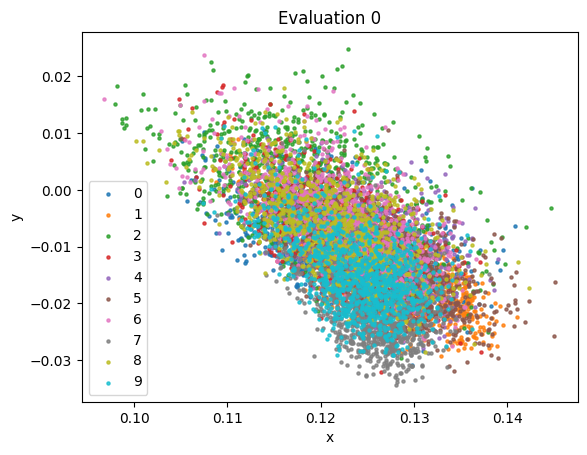

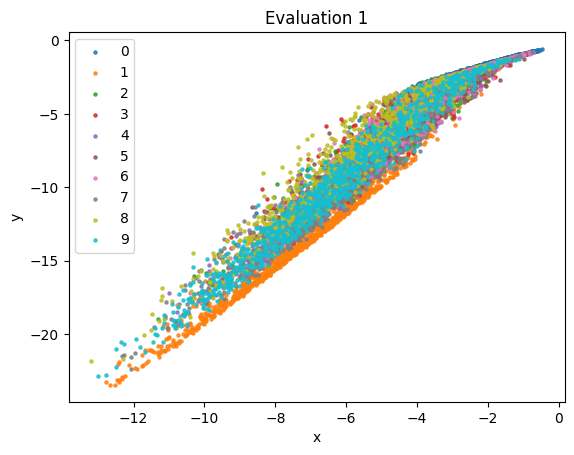

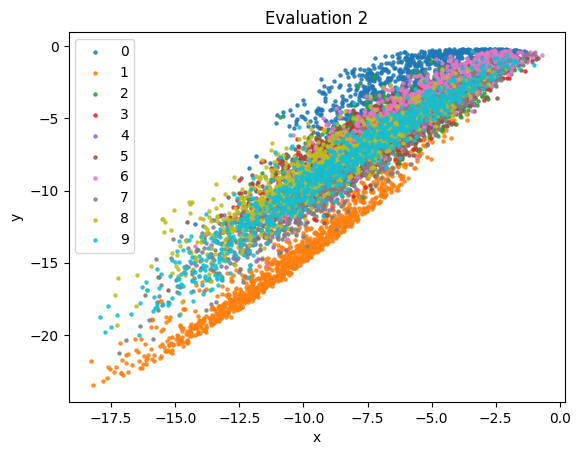

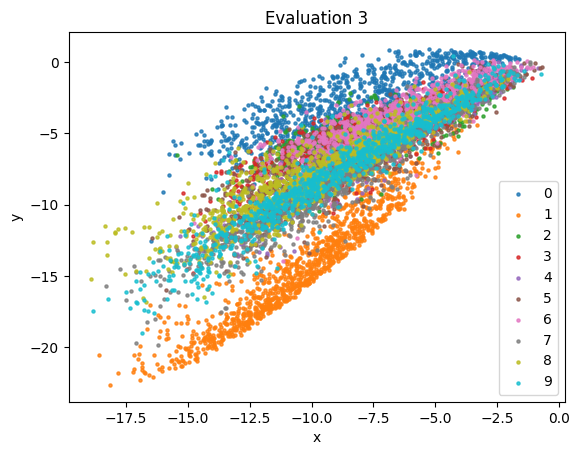

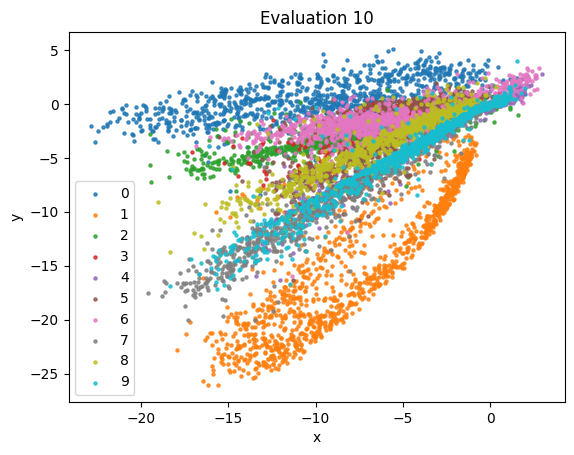

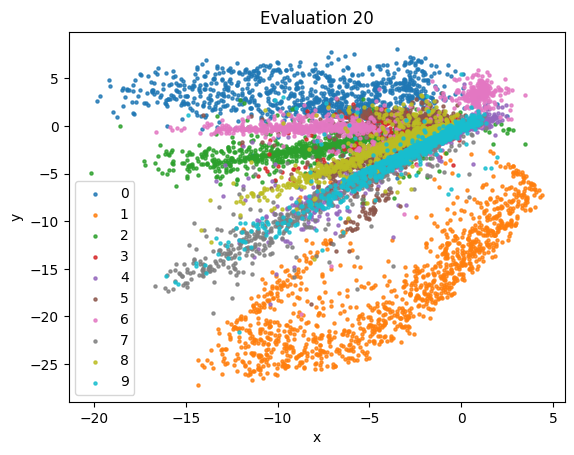

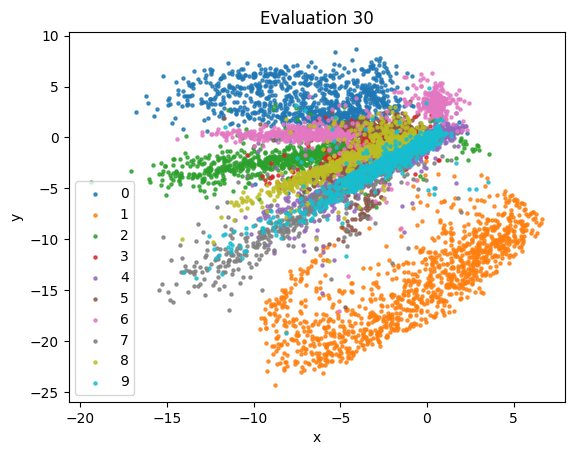

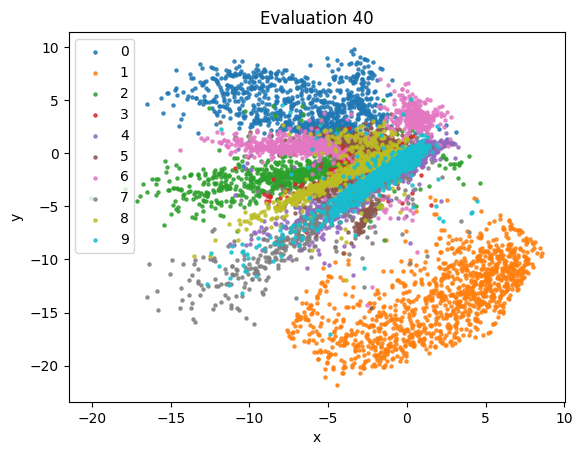

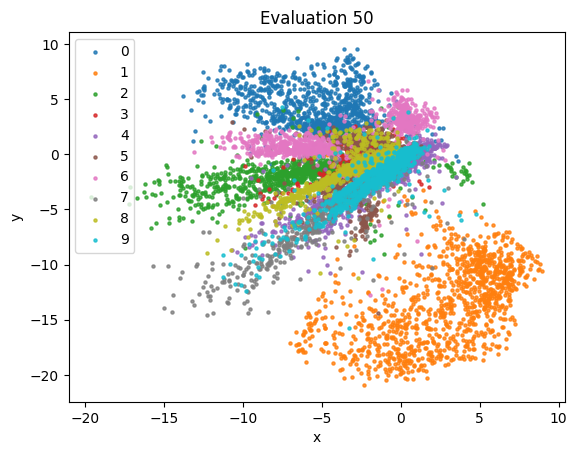

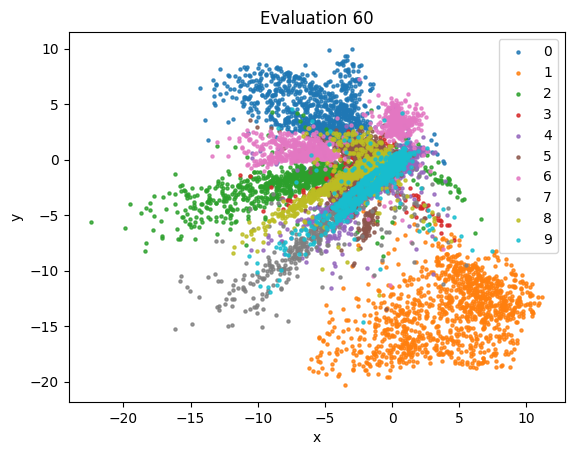

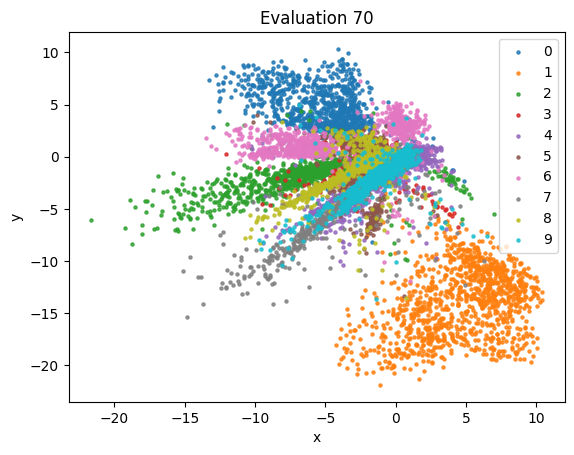

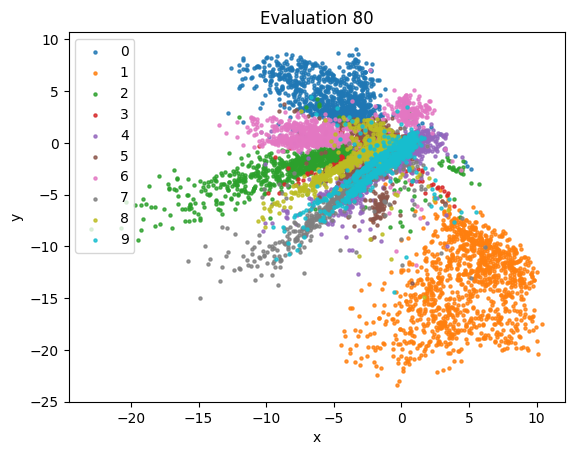

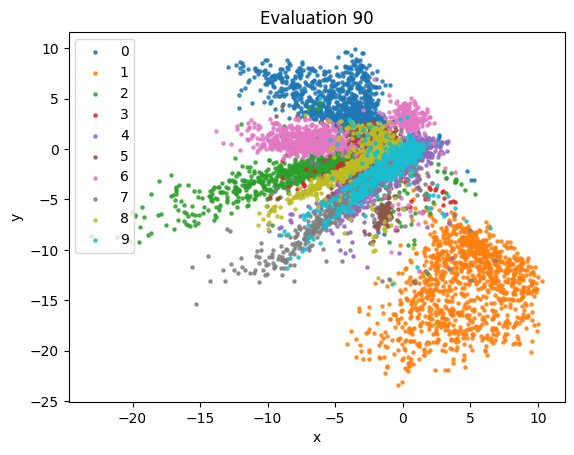

In [ ]:
def build_embedding_plot(encoding,title):
  encoding= pd.DataFrame(encoding, columns=["x","y","class"])
  encoding = encoding.sort_values(by="class")
  encoding["class"]= encoding["class"].astype(int).astype(str)

  for grouper,group in encoding.groupby("class"):
    plt.scatter(x=group["x"],y=group["y"],label=grouper,alpha=0.8,s=5)

  plt.title(title)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()
  plt.show()

for i in range(len(encoded_data_per_eval)):
  if i<=3 or i%10==0:
    build_embedding_plot(encoded_data_per_eval[i],"Evaluation "+str(i))


<hr size=5 color=magenta>

### Now We Will Use CNN Instead of ANN (Since We Know on a grid like data e.g. Image data, CNN provides better results compared to ANN)

In [ ]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, channels_bottleneck=4):

        super().__init__()
        self.bottleneck = channels_bottleneck
        self.in_channels = in_channels

        self.encoder_conv = nn.Sequential(

            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=self.bottleneck, kernel_size=3, stride=2, padding=1),

        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.bottleneck, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=8, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()

        )

    def forward_enc(self, x):
        conv_enc = self.encoder_conv(x)
        return conv_enc

    def forward_dec(self, x):
        return self.decoder_conv(x)

    def forward(self, x):

        batch_size, num_channels, height, width = x.shape
        enc = self.forward_enc(x)
        dec = self.forward_dec(enc)

        return enc, dec

conv_model = ConvolutionalAutoEncoder()
conv_model, train_losses, evaluation_losses, conv_encoded_data_per_eval = train(conv_model,
                                                                                train_set,
                                                                                test_set,
                                                                                batch_size=64,
                                                                                training_iterations=25000,
                                                                                evaluation_iterations=250)

  0%|          | 0/25000 [00:00<?, ?it/s]

Training Loss: 0.27020853757858276
Evaluation Loss: 0.2417786625350357
Training Loss: 0.16507219529151917
Evaluation Loss: 0.07294457821044953
Training Loss: 0.05113209818303585
Evaluation Loss: 0.03698321847114593
Training Loss: 0.02285410661622882
Evaluation Loss: 0.014835974729507212
Training Loss: 0.01266540900617838
Evaluation Loss: 0.01075370320575727
Training Loss: 0.010172917619347572
Evaluation Loss: 0.00923942459248908
Training Loss: 0.00909254732169211
Evaluation Loss: 0.008408247163981959
Training Loss: 0.008333213105797767
Evaluation Loss: 0.007814163715833692
Training Loss: 0.00778793416917324
Evaluation Loss: 0.007287823601038593
Training Loss: 0.00728856941126287
Evaluation Loss: 0.006861398367294271
Training Loss: 0.006901315603405237
Evaluation Loss: 0.00652012204941196
Training Loss: 0.006565602365881205
Evaluation Loss: 0.006238373847690167
Training Loss: 0.006286432920023799
Evaluation Loss: 0.006005424878613394
Training Loss: 0.006078367738053202
Evaluation Loss: 

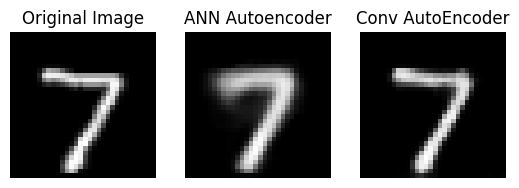

In [ ]:
generated_index = 0
image, label = test_set[generated_index]

_, annReconstructed = model(image.unsqueeze(0).to(device))
_, cnnReconstructed = conv_model(image.unsqueeze(0).to(device))

annReconstructed = annReconstructed.to("cpu").detach().numpy()
cnnReconstructed = cnnReconstructed.to("cpu").detach().numpy()

fig, ax = plt.subplots(1,3)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original Image")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(annReconstructed.squeeze(), cmap="gray")
ax[1].set_title("ANN Autoencoder")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

ax[2].imshow(cnnReconstructed.squeeze(), cmap="gray")
ax[2].set_title("Conv AutoEncoder")
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].axis("off")


plt.show()
